## Conditional function

In [27]:

# Define a function for custom max value selection
def find_max_values(batch):
    length = len(batch)
    if length in [4, 5, 6]:  # Special case for lengths 4, 5, and 6
        # Find max value from the first 3 elements
        max_first_part = max(batch[:3])
        # Find max value from the remaining elements
        max_second_part = max(batch[3:]) if length > 3 else None
        return [max_first_part, max_second_part] if max_second_part is not None else [max_first_part]
    elif length in [7, 8, 9]:  # Special case for lengths 8 and 9
        # Max from the first 3 values
        max_first_part = max(batch[:3])
        # Max from the next 3 values
        max_second_part = max(batch[3:6])
        # Max from the remaining values
        max_remaining = max(batch[6:]) if length > 6 else None
        return [max_first_part, max_second_part, max_remaining] if max_remaining is not None else [max_first_part, max_second_part]
    elif length == 1:  # Special case for length 1
        return batch  # Return the single value as is
    elif length == 3:  # Special case for length 3
        return [max(batch)]  # Return the maximum of the batch
    else:  # Default case (no special rule)
        return [max(batch)]  # Return the overall max

def rx_data(value_p):
    s_batch = []
    rx_mess = []
    len_b = []
    start_idx = None
    for i, avg_pixel in enumerate(value_p):
        int_avg = int(avg_pixel)
        if int_avg == 0:
            if start_idx is not None and start_idx<i:
                b_in_b = value_p[start_idx:i]
                # call the max value function
                max1_values = find_max_values(b_in_b)
                rx_mess.append(max1_values)
                s_batch.append(b_in_b)
                len_b.append(len(b_in_b))
            start_idx = None
        else:
            if start_idx is None:
                start_idx = i

    if start_idx is not None and start_idx<len(value_p):
        bin_b = value_p[start_idx:]
        # call the max value function
        max2_values = find_max_values(bin_b)
        rx_mess.append(max2_values)
        s_batch.append(bin_b)
        len_b.append(len(bin_b))

    # print("batch value_p",s_batch)
    # print("each batch length",len_b)
    # print("rx message",rx_mess)

    # Flatten the list of max values batches and remove brackets/parentheses
    flat_max_values = [value for batch in rx_mess for value in batch]

    if len(flat_max_values)==128:
        # Convert to a space-separated string for cleaner output
        result = flat_max_values
        return result



## data decoding

In [30]:
import numpy as np
from PIL import Image
import os

for k in range(1, 2):
    # Define input and output directories
    input_directory = fr'D:\My File\OCC_Nov_11\Datasets_L8_8_subcarrier\3_rx_image\m{k}'  # Folder containing the tiff images
    output_directory= fr'D:\My File\OCC_Nov_11\Datasets_L8_8_subcarrier\4_rx_decoded_data\m{k}'  # Folder to save the decoded data

    # Define the batch size
    batch_size = 128  # Adjust the batch size as per your needs

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Get all TIFF files in the input directory
    tiff_files = [f for f in os.listdir(input_directory) if f.endswith('.tiff')]

    # Define the threshold
    threshold = 15.0  # Define threshold for batch separation

    # Loop over all TIFF files in the input directory
    for tiff_file in tiff_files:
        # Load each TIFF image
        image_path = os.path.join(input_directory, tiff_file)
        image = Image.open(image_path)
        image_data = np.array(image).astype(float)

        # Extract specific column range (e.g., columns 850 to 1000)
        columns_range_data = image_data[:, 900:1200]
        column_avg = np.mean(columns_range_data, axis=1)

        # Flatten the array of column-averaged values
        flat_column_avg = column_avg.flatten()
        #print("average value",flat_column_avg)
        np.savetxt('column_flat_column_avg_values.txt', flat_column_avg, fmt='%.3f')

        # updated_data, removed_indices = remove_consecutive_duplicates(flat_column_avg)
        # print("Updated Data:", updated_data)
        # print("Removed Indices:", removed_indices)
        # Initialize variables for batch creation
        # Initialize variables for batch creation
        batches_column_avg = []  # List to store batches

        l= len(flat_column_avg)
        start_idx = None

        i=0
        while i<l:
            if flat_column_avg[i]==0:
                zero_count =1
                while i+zero_count<l and flat_column_avg[i+zero_count]==0:
                    zero_count+=1
                
                if zero_count>3:
                    if start_idx is not None:
                        batches_column_avg.append(np.round(flat_column_avg[start_idx:i],5))
                        start_idx = None
                    i+= zero_count-1
                else:
                    if start_idx is None:
                        start_idx=i+zero_count
                    i+=zero_count-1
            else:
                if start_idx is None:
                    start_idx = i
            i+=1
        
        if start_idx is not None and start_idx<l:
            batches_column_avg.append(np.round(flat_column_avg[start_idx:],5))

        #print("Batches with Zeros <= 3 Included:", batches_column_avg)

        # Process each batch and average every two pixels, excluding first and last batch
        for i, batch in enumerate(batches_column_avg[0:], start=0):  # Exclude first and last batch
            #print(f" Batch {i}: Original Data{np.array(batch).shape}")
            #print(np.array(np.round(batch,4)))  # Print the original batch content
            output_rx = rx_data(batch)
            # Check if the current batch has the required length
            if output_rx is not None:
                if len(output_rx) == batch_size:
                    # Convert list to comma-separated string
                    formatted_list = ', '.join(map(str, output_rx))

                    # Save the batch to a text file (e.g., m1.txt, m2.txt, etc.)
                    output_file_name = os.path.join(output_directory, f"{os.path.splitext(tiff_file)[0]}m{i}.txt")
                    with open(output_file_name, 'w') as file:
                        file.write(f"{formatted_list}")

                    print("rx_message", output_rx)
            
print("Processing complete for all TIFF files.")


rx_message [np.float64(8.7), np.float64(7.12333), np.float64(5.82667), np.float64(6.20333), np.float64(10.76), np.float64(6.31667), np.float64(7.46), np.float64(16.37), np.float64(12.45667), np.float64(8.39333), np.float64(5.46333), np.float64(9.8), np.float64(11.04), np.float64(15.77667), np.float64(11.50333), np.float64(5.52333), np.float64(17.93), np.float64(11.61333), np.float64(8.26), np.float64(17.58667), np.float64(10.67), np.float64(5.83), np.float64(11.02), np.float64(12.38333), np.float64(9.45667), np.float64(11.19), np.float64(16.16667), np.float64(13.70667), np.float64(12.39333), np.float64(18.55), np.float64(14.02667), np.float64(15.51), np.float64(16.99667), np.float64(13.70333), np.float64(15.27667), np.float64(20.50667), np.float64(12.87), np.float64(14.6), np.float64(17.51333), np.float64(13.42), np.float64(14.96333), np.float64(16.08333), np.float64(14.98), np.float64(11.54667), np.float64(17.86667), np.float64(9.44333), np.float64(7.02667), np.float64(21.39), np.floa

## Message extraction

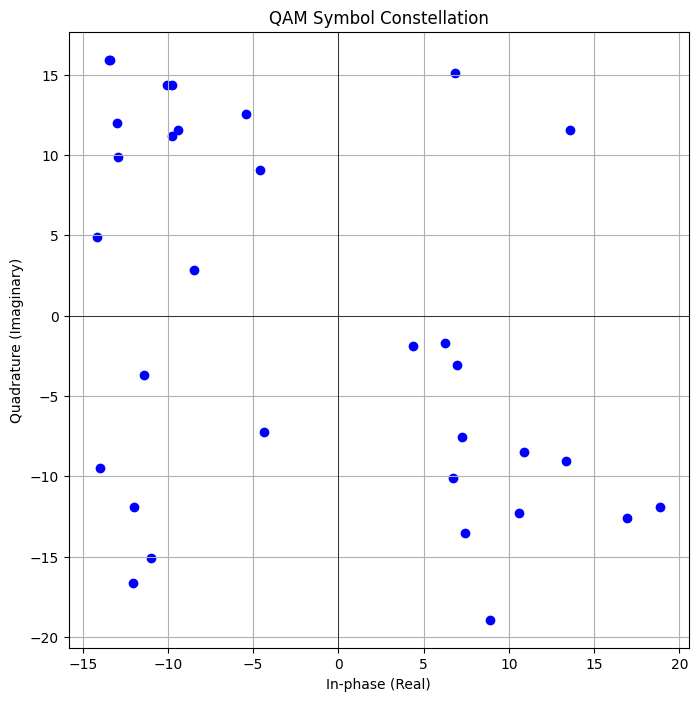

Decoded message: hell


In [23]:
import numpy as np
rx_data = np.array([17.11667 ,18.69667 ,17.40333 ,13.40333 ,20.68 ,16.76333 ,8.58667 ,25.38 ,18.68333 ,6.52333 ,15.47667 ,19.55667 ,18.39333 ,24.23667 ,15.69667 ,18.48667 ,21.73 ,20.05667 ,18.77333 ,18.27 ,22.14333 ,8.85 ,11.78333 ,26.53333 ,25.26667 ,19.34333 ,16.07333 ,23.46667 ,17.92667 ,11.83667 ,13.09 ,16.09 ,22.46333 ,18.38667 ,19.13667 ,18.05 ,19.31667 ,13.12 ,10.34333 ,23.74 ,19.12333 ,11.99667 ,19.89667 ,23.6 ,22.7 ,21.33667 ,7.59 ,18.21333 ,21.97 ,17.58 ,22.81667 ,18.12667 ,19.37333 ,12.0 ,10.39 ,23.88333 ,22.09333 ,12.1 ,19.41333 ,23.88 ,22.84333 ,17.46667 ,22.36667 ,18.32333 ,19.47667 ,17.62333 ,22.88 ,17.83333 ,20.99333 ,12.17 ,12.24 ,24.06 ,29.59 ,23.14333 ,13.36333 ,27.46333 ,16.68333 ,9.16 ,16.54333 ,19.17667 ,13.47333 ,12.18 ,16.55 ,14.99333 ,26.66 ,21.09667 ,13.51 ,24.30333 ,23.15667 ,13.80667 ,16.76 ,32.02 ,19.71333 ,16.31 ,16.76 ,12.69 ,19.74667 ,25.89333 ,15.36667 ,19.81 ,23.26333 ,18.34667 ,16.27667 ,23.41 ,19.57 ,13.67667 ,10.69667 ,20.15667 ,26.45 ,16.99333 ,20.09667 ,19.91 ,16.89333 ,16.87 ,7.56 ,23.6 ,27.95667 ,15.32667 ,23.05667 ,23.48667 ,13.63333 ,16.97 ,23.54667 ,19.93333 ,24.01667 ,17.14 ,8.84667 ,19.25667])
rx_data.shape
rx_train = rx_data
rx_reshaped = rx_train.reshape(-1, 128)

# Clip extreme values in each batch
clipped_data = []
for batch in rx_reshaped:
    lower_threshold = np.percentile(batch, 0)
    upper_threshold = np.percentile(batch, 100)
    batch_clipped = np.clip(batch, lower_threshold, upper_threshold)
    clipped_data.append(batch_clipped)
clipped_data = np.array(clipped_data).reshape(-1)  # Flatten back to original shape
# Load the datasets into numpy arrays (assuming they're comma-separated)
clip_rx_data = clipped_data.reshape(-1,128)

# Make the data to complex format
complex_ofdm = clip_rx_data + 0j
# print("Complex OFDM Symbols:")
# print(complex_ofdm)

## perform reshape
ofdm_symbols_reshaped = complex_ofdm.reshape(-1, 8) # change 16 t0 8 for 8 subcarrier
# print(ofdm_symbols_reshaped)

# after fft hermitian symbol created
fft_ofdm_symbols = np.fft.fft(ofdm_symbols_reshaped, axis=1)
# print(fft_ofdm_symbols)
# print(fft_ofdm_symbols.shape)

# # equalization
# tx_pilots = np.array([1 + 1j, 1 - 1j])  # Known transmitted pilots
# pilot_indices = [2, 6]  # Indices of the pilots
# noise_variance = 0.01  # Noise variance
# # Initialize equalized data array
# equalized_data = np.zeros_like(fft_ofdm_symbols, dtype=complex)
# # Process each row
# for i, rx in enumerate(fft_ofdm_symbols):
#     # Step 1: Extract received pilot values
#     rx_pilots = rx[pilot_indices]
#     # Step 2: Calculate channel response (H) at pilot positions
#     H_pilots = rx_pilots / tx_pilots
#     # Step 3: Interpolate H for all subcarriers (linear interpolation)
#     H = np.zeros_like(rx, dtype=complex)
#     H[pilot_indices] = H_pilots  # Assign known pilot values
#     H = np.interp(
#         np.arange(len(rx)),
#         pilot_indices,
#         H_pilots.real
#     ) + 1j * np.interp(
#         np.arange(len(rx)),
#         pilot_indices,
#         H_pilots.imag
#     )
#     # Step 4: Apply MMSE equalization
#     H_conj = np.conj(H)  # Complex conjugate of H
#     H_magnitude_sq = np.abs(H)**2  # Squared magnitude of H
#     mmse_weights = H_conj / (H_magnitude_sq + noise_variance)  # MMSE weights
#     equalized_data[i] = mmse_weights * rx  # Equalized symbols
# # Display results
# print("Equalized Data:")
# print(equalized_data)

# hermirian to QAM-4 original signal
def reverse_hermitian_symmetry_matrix(hermitian_symmetric_matrix):
    """Recover the QAM symbols from a matrix of Hermitian-symmetric OFDM symbols.
    Each row of the input matrix represents a 8-subcarrier OFDM symbol.
    """
    num_rows = hermitian_symmetric_matrix.shape[0]  # Get the number of rows
    qam_symbols_matrix = np.zeros((num_rows, 2), dtype=complex)  # Initialize the output array
    
    for i in range(num_rows):
        # Extract the original QAM symbols from each row
        qam_symbols_matrix[i, :] = hermitian_symmetric_matrix[i, [1,3]]
    return qam_symbols_matrix

qam_symbols_matrix = reverse_hermitian_symmetry_matrix(fft_ofdm_symbols)
# # Print the recovered QAM symbols for each row
# print(qam_symbols_matrix)

# Concatenate all rows into a single row
QAM_16 = np.concatenate(qam_symbols_matrix)

## QAM constellation for original signal
import numpy as np
import matplotlib.pyplot as plt
# Plot the constellation diagram
plt.figure(figsize=(8, 8))
plt.scatter(QAM_16.real, QAM_16.imag, color='blue', marker='o')
# Add grid lines and labels
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.title("QAM Symbol Constellation")
plt.xlabel("In-phase (Real)")
plt.ylabel("Quadrature (Imaginary)")
# Show the plot
plt.show()

## hermirian to QAM-16 equalize signal
def qam4_to_binary(symbols):
    """Convert QAM-16 symbols back to a binary list, replace unmatched symbols with '1010'."""
    binary_list = []
    for RI in symbols:
        R = np.real(RI)
        I = np.imag(RI)

        if R >=0 and I>=0 :
            binary_list.append('00')
        elif R < 0 and I>=0 :
            binary_list.append('10')
        elif R < 0 and I < 0 :
            binary_list.append('11')
        elif R >=0 and I< 0 :
            binary_list.append('01')
        
    # Join the list of binary strings and convert them into individual bits
    return binary_list

binary_output = qam4_to_binary(QAM_16)
# print("Binary Output:", binary_output)
# Convert list to a single string
binary_string = ''.join(binary_output)
# print(binary_string)

## FEC decoding using reed-solomon decoder
import reedsolo
# Helper function to convert a binary string to bytes
def binary_to_bytes(binary_str):
    return bytes(int(binary_str[i:i+8], 2) for i in range(0, len(binary_str), 8))

# Helper function to convert bytes back to binary string
def bytes_to_binary(byte_data):
    return ''.join(format(byte, '08b') for byte in byte_data)

# Initialize the Reed-Solomon codec
n = 15
k = 11
rs = reedsolo.RSCodec(n - k)
# Convert binary string to bytes
binary_bytes = binary_to_bytes(binary_string)
# Decoding the corrupted data (and correcting errors)
decoded_tuple = rs.decode(binary_bytes)
# Extract the corrected message (first element of the tuple)
corrected_message = decoded_tuple[0]
# Convert the corrected bytes back to binary
decoded_binary = bytes_to_binary(corrected_message)
# print(f"Original Binary Data: {binary_string}")
# print(f"Corrected Binary Data: {decoded_binary}")

## binary to original message
def bits_to_string(bits):
    """Convert a list of bits back to a string."""
    chars = [chr(int(''.join(map(str, bits[i:i + 8])), 2)) for i in range(0, len(bits), 8)]
    return ''.join(chars)

# Convert the binary string to a list of integers (0s and 1s)
corrected_bits = [int(bit) for bit in decoded_binary]
# Convert the bits to the original string
decoded_message = bits_to_string(corrected_bits)
print(f"Decoded message: {decoded_message}")

